# Base de classification en Turc

    - Transformers : Summarization : 2 modèles --> 2 Résumés / Puis score de similarités de ces 2 résumés
    Noter que l'on peut faire aussi la similarité des textes (autre note ?) et non du résumé
    - Text classification sur une base de catégories "Presse" : sport - actaulités - économie - etc
    - Sentiment analysis : voir si le ton du texte est de même type 
    - Les 2 derniers classifier seronts utilisés en produit scalaire : Par Catégorie : texte1: note1 - texte2 : note2
    et donc sum(notes_par_catégorie) = sum(note1*note2) * 100 au bout (note sur 100)

In [1]:
import pandas as pd
import pke
import spacy
import torch
import stanza
import spacy_stanza
import warnings
import string
from gensim.models import KeyedVectors
import enchant    # Pour correction orthographique de synonymes
import numpy as np
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import BertTokenizerFast, EncoderDecoderModel
from transformers import AutoModelForTokenClassification, AutoTokenizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**Selection des modèles NLP : ici FRANCAIS**

In [2]:
# Chargement pour l'utilisation de Spacy  - Pas de turc
# nlp_tr = spacy.load("fr_core_news_sm")

In [3]:
dico_spacy = {}   # 'en':nlp_en,'de':nlp_de,'es':nlp_es,'pl':nlp_pl  - POUR MEMOIRE
langues = ['en','fr','es','de','pl','ar','tr']

In [4]:
# Chargement du modèle Word2Vec pour utilisation de synonymes
model_gensim = KeyedVectors.load_word2vec_format("D:/Users/STG-SDU/Documents/NLP/turkish", binary=True, unicode_errors="ignore")

In [5]:
# Stopwords Français NLTK + Spacy 
#stopWords = list(nlp_fr.Defaults.stop_words)
stopwords_tr = list(stopwords.words('turkish'))  
#stopwords_fr = list(set(stopwords_fr + stopWords))
stopwds_lg = {'tr':stopwords_tr}

In [6]:
# correcteur orthographique pour validation des synonymes OPTIONNEL CAR NON NECESSAIRE
# d = enchant.Dict("fr") 

In [7]:
# Named entity recognition turc 
model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner=pipeline('ner', model=model, tokenizer=tokenizer)

**Sélection des modèles Transformers : Summary - Text Classification - Sentiment Analysis - Similarity**

In [8]:
# Modèle transformers résumé 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-turkish-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

def summarizer1(text):
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    output = model.generate(input_ids, attention_mask=attention_mask)
    return tokenizer.decode(output[0], skip_special_tokens=True)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [9]:
# Modèles Transformers de Résumé (NB : Ne pas oublier d'ajouter la truncation pour tous les modèles, peut être source d'erreur)
#summarizer1 = pipeline("summarization", model="mrm8488/bert2bert_shared-turkish-summarization", truncation = "only_first")
summarizer2 = pipeline("summarization", model="ozcangundes/mt5-small-turkish-summarization", truncation = "only_first")

In [10]:
# Textes classification ou Zero shot classification (permet de chosiri nos propres thèmes)
text_clf1 = pipeline("text-classification", model = "savasy/bert-turkish-text-classification", truncation = "only_first")   # 10 actégories, voir hugging face
# labels = ['world','economy','technology','health','politics','sport','culture']

text_clf2 = pipeline('zero-shot-classification', model="serdarakyol/interpress-turkish-news-classification",truncation = "only_first")
candidate_labels = ['Culture-Art','Politics','Economy','World','Health','Technology','Agenda', 'Sport','Education','Magazine']

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [11]:
# Sentiment Analysis
sentiment1 = pipeline("text-classification", model = 'savasy/bert-base-turkish-sentiment-cased')
sentiment2 = pipeline('sentiment-analysis', model="symanto/xlm-roberta-base-snli-mnli-anli-xnli")

In [12]:
# ENCODAGE AVEC SENTENCE TRANSFORMER
from sentence_transformers import SentenceTransformer,util
encoder = SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli")
def score_similarite(sentence1,sentence2):
    # attention, pour que torch fonctionne en dimension sentence1 (et 2) est une liste simple
    embed1 = encoder.encode(sentence1, convert_to_tensor=True)
    embed2 = encoder.encode(sentence2, convert_to_tensor=True)
    return round(float(util.pytorch_cos_sim(embed1,embed2))*100,2)

**Selection Data par langues**

In [13]:
data = pd.read_csv('train_data_prep_v1.csv')

In [14]:
data

,pair_id,pair_lang,source_url_1,publish_date_1,source_url_2,publish_date_2,title_1,text_1,meta_description_1,meta_keywords_1,...,text_2,meta_description_2,meta_keywords_2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,1484084337_1484110209,en_en,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Police in West Virginia say a suspected drunke...,"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",Haitian President Jovenel Moïse has broken wit...,"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,1484396422_1483924666,en_en,https://www.stlucianewsonline.com,Wed Jan 1 21:17:15 2020,https://www.thestar.com,Wed Jan 1 00:00:00 2020,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,-,[''],...,BERLIN - A fire at a zoo in western Germany in...,BERLIN - A fire at a zoo in western Germany in...,"['smg2_world', 'smg_europe', 'smg2_news']",4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,1484698254_1483758694,en_en,https://www.teaparty.org,NaN,https://www.timesofisrael.com,NaN,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,NaN,[''],...,"PALM BEACH, United States — US President Donal...",US president says response to rioting by pro-I...,[''],1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,1576314516_1576455088,en_en,https://gadgets.ndtv.com,NaN,https://gadgets.ndtv.com,NaN,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Zomato on Tuesday announced it has acquired Ub...,['zomato uber eats business acquisition india ...,...,Rapid digitisation and growth in both online b...,The report by Google and Boston Consulting Gro...,['indian online food delivery market to hit us...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,1484036253_1483894099,en_en,https://news.yahoo.com,Wed Jan 1 08:57:59 2020,https://www.channelnewsasia.com,NaN,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India has approved its third lunar mission mon...,[''],...,BANGALORE: India plans to make a fresh attempt...,India plans to make a fresh attempt to land an...,"['India', 'space']",1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,1586195445_1598778991,tr_tr,http://www.haberler.com,NaN,https://www.haberler.com,NaN,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden za...","Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",...,BM'den Yemen'de kadınların doğumda ölüm riski ...,BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",1.0,2.000000,2.000000,4.000000,3.000000,1.000000,1.000000
4960,1590915424_1590940388,tr_tr,https://www.haberler.com,NaN,https://www.aksam.com.tr,NaN,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4961,1526157103_1492737005,tr_tr,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,Saray da çare olmadı: 'Borca boğulan dev kulüp...,\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca""

In [15]:
# remémorer numéro de ligne - compléter les Nan
data['ligne'] = data.index
data = data.fillna('')

In [16]:
# séparation des datasets, le dernier étant à traduire en plus
turc = data.loc[data.pair_lang == 'tr_tr',['ligne','title_1','title_2','text_1','text_2','Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone']].reset_index(drop=True)

**Tests divers et Fonctions nécessaires**

In [17]:
print(summarizer1(turc.text_1[1]))
print(summarizer1(turc.text_2[1]))

Star Gazetesi yazarı Baha Baha Baha, Ağrı'da kaçırılan komşusu Leyla Özdoğanlar'la ilgili dehşet bir ayrıntı aktardı. Baha'nın anlattığına göre Leyla'nın babası İrem'e ait gri bir araba geldi.
2015 yılında Manisa'da evlenen Ali Akkoç, iş adamı eşi Baha Hanım tarafından dolandırıldığı iddiasıyla savcılığa şikayette bulundu. Mahkeme Akkoç'un eşini suçladı ve aldattığını söyledi.


In [18]:
print(summarizer2(turc.text_1[3])[0]['summary_text'])
print(summarizer2(turc.text_2[3])[0]['summary_text'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Ekonomik Örgütler , Sosyal Sigortalar’a kayıtlı tüm
Kuzey Kıbrıs Türk Cumhuriyeti ( KKTC ) Başbakanı Ersin


In [19]:
print(ner("Mustafa Kemal Atatürk 19 Mayıs 1919'da Samsun'a ayak bastı."))
print(ner("Star Gazetesi yazarı Baha Baha Baha, Ağrı'da kaçırılan komşusu Leyla Özdoğanlar'la ilgili dehşet bir ayrıntı aktardı. Baha'nın anlattığına göre Leyla'nın babası İrem'e ait gri bir araba geldi."))

[{'entity': 'B-PER', 'score': 0.99385166, 'index': 1, 'word': 'Mustafa', 'start': 0, 'end': 7}, {'entity': 'I-PER', 'score': 0.9881671, 'index': 2, 'word': 'Kemal', 'start': 8, 'end': 13}, {'entity': 'I-PER', 'score': 0.9957979, 'index': 3, 'word': 'Atatürk', 'start': 14, 'end': 21}, {'entity': 'B-LOC', 'score': 0.9059983, 'index': 9, 'word': 'Samsun', 'start': 39, 'end': 45}]
[{'entity': 'B-ORG', 'score': 0.9675711, 'index': 1, 'word': 'Star', 'start': 0, 'end': 4}, {'entity': 'I-ORG', 'score': 0.9528284, 'index': 2, 'word': 'Gazetesi', 'start': 5, 'end': 13}, {'entity': 'B-PER', 'score': 0.9487007, 'index': 4, 'word': 'Baha', 'start': 21, 'end': 25}, {'entity': 'I-PER', 'score': 0.9723536, 'index': 5, 'word': 'Baha', 'start': 26, 'end': 30}, {'entity': 'I-PER', 'score': 0.77037245, 'index': 6, 'word': 'Baha', 'start': 31, 'end': 35}, {'entity': 'B-LOC', 'score': 0.9961054, 'index': 8, 'word': 'Ağrı', 'start': 37, 'end': 41}, {'entity': 'B-PER', 'score': 0.8367971, 'index': 15, 'word'

In [20]:
# Fonction de calcul du score (produit scalaire) pour résultats de classifaction
def fonction_produit_dotcom(liste_categor, dico_scores1,dico_scores2):
    """"dico scores sont les résultats obtenus pour chaque catégorie des textes 1 et 2"""
    result = 0.0
    for cat in liste_categor:
        result += round(dico_scores1[cat] * dico_scores2[cat],4)
    return result * 100

In [21]:
# transformation des résultats du transformer type1
def transform_text_clf1(liste_dico):
    res = {}
    for dic in liste_dico:
        res[dic['label']] = dic['score']
    return res

In [22]:
# transformation des résultats du transformer type2
def transform_text_clf2(liste_cat,liste_sc):
    res = {}
    for i in range(len(liste_cat)):
        res[liste_cat[i]] = liste_sc[i]
    return res

In [23]:
# Tests
liste_categories = ['world','economy','technology','health','politics','sport','culture']
scores1 = transform_text_clf1(text_clf1(turc.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(text_clf1(turc.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_categories, scores1,scores2))

{'world': 0.00025739395641721785, 'economy': 0.9987984895706177, 'culture': 0.00010630450560711324, 'health': 0.00017764765652827919, 'politics': 0.00026767802773974836, 'sport': 0.00010267787729389966, 'technology': 0.0002898280799854547}
{'world': 0.000552773883100599, 'economy': 0.9935751557350159, 'culture': 0.00016379126464016736, 'health': 0.0006710650050081313, 'politics': 0.003993504215031862, 'sport': 0.00016503150982316583, 'technology': 0.0008786647813394666}
99.24


In [24]:
# Tests
classes = text_clf2(turc.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf2(turc.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

10.0


In [25]:
# Tests sentiment analysis
liste_labels = ['negative','positive']
scores1 = transform_text_clf1(sentiment1(turc.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment1(turc.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_labels, scores1,scores2))

{'negative': 0.16613493859767914, 'positive': 0.8338650465011597}
{'negative': 0.8673121929168701, 'positive': 0.1326877623796463}
25.470000000000002


In [26]:
# ATTENTION CE MODELE SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
liste_sentiments = ['ENTAILMENT','NEUTRAL','CONTRADICTION']
scores1 = transform_text_clf1(sentiment2(turc.title_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment2(turc.title_2[3],return_all_scores=True)[0])
scores3 = transform_text_clf1(sentiment2(turc.text_1[3],return_all_scores=True)[0])
scores4 = transform_text_clf1(sentiment2(turc.text_2[3],return_all_scores=True)[0])
print(fonction_produit_dotcom(liste_sentiments, scores1,scores2))
print(fonction_produit_dotcom(liste_sentiments, scores3,scores4))

15.049999999999999
87.17


In [27]:
# TESTS SCORES DE SIMILARITES : Titres, Textes complets (attention Truncation ...)
print(score_similarite(turc.title_1[3],turc.title_2[3]))
print(score_similarite(turc.text_1[3],turc.text_2[3]))
print(score_similarite(summarizer1(turc.text_1[0]),summarizer1(turc.text_2[0])))
print(score_similarite(summarizer2(turc.text_1[0])[0]['summary_text'],summarizer2(turc.text_2[0])[0]['summary_text']))

54.75
35.34
6.88
-1.66


In [28]:
# Essais de synonymies à utiliser pour sorties PKE, termes prinicpaux
syns = model_gensim.most_similar("ölüm", topn=10)
syns

[('ölümün', 0.5036850571632385),
 ('öldürülme', 0.4868655204772949),
 ('cinayet', 0.47994905710220337),
 ('tutuklanma', 0.4654034674167633),
 ('recm', 0.45784449577331543),
 ('öldürme', 0.4563998878002167),
 ('ölümle', 0.4523148834705353),
 ('kalım', 0.4506659507751465),
 ('yaşlılık', 0.44606664776802063),
 ('ölüme', 0.4449857473373413)]

In [29]:
# Fonctions de summarization 
def summarization(texte):
    return summarizer1(texte), summarizer2(texte)[0]['summary_text']

In [30]:
dico_classifiers = {'text_clf1': 'score_classif1','text_clf2':'score_classif2','sentiment1':'score_sentiment1',
                    'sentiment2': 'score_sentiment2'}
dico_categories = {'text_clf1': liste_categories,'text_clf2':candidate_labels,'sentiment1':liste_labels,
                    'sentiment2': liste_sentiments}

In [31]:
# Fonctions de classification et sentiment analysis
def classification(texte,clf):
    # assume nms des classifiers et methode de transformation
    if clf == "text_clf1":
        try:
            scores = transform_text_clf1(text_clf1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "text_clf2":                                 
        try:
            classes = text_clf2(texte,dico_categories['text_clf2'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])                          
    elif clf == "sentiment1":
        try:
            scores = transform_text_clf1(sentiment1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment2":
        try:
            scores = transform_text_clf1(sentiment2(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    else:
        return 'error'

In [32]:
# Prétraitement NLP pour PKE : suppression des mots de moins de 2 lettres non numériques
def supp_moins_2_lettres_stopwords(phrase,stopwd):
    temp = phrase.split(' ')
    res = ''
    for mot in temp:
        if mot not in stopwd and (len(mot)>2 or (len(mot)>0 and mot[0] in ['0','1','2','3','4','5','6','7','8','9'])):
            res += mot + ' '
    return res[:-1]

In [33]:
# Prétraitement NLP pour PKE : suppression des traits d'union(regroupe)/ des apostrophes / ponctuations
def modif(texte,stopmots):
    # modifications simples des textes : ponctuations, petits mots, stopwords (à faire pour entités et pke textes)
    texte=re.sub('\'',' ',texte)   # suppression apostrophe
    texte=re.sub('-','',texte)    # suppression trait union
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # suppression de toutes les ponctuations
    texte=regex.sub(' ',texte)
    texte = supp_moins_2_lettres_stopwords(texte,stopmots)
    return texte

In [34]:
# Ajout des synonymes (existants en orthographe) à la suite de l'analyse pke
def ajout_synonymes(mot, correct_ortho = False):
    # on ajoute les 10 premiers synonymes existants, on vérifie orthographe (optionnel)
    syns = model_gensim.most_similar(mot,topn = 20)
    if correct_ortho == True:
        res = []
        for m in syns:
            if d.check(m[0]):   #  il y a le mot et son pourcentage d'importance
                res.append(m)
        syns = res
    return syns[:10]

Quelle est la bonne méthodologie à appliquer PKE ??? : Noms Ok - Verbes ? - Adjectifs ? - Noms propres ?
Quelle quantité de mots prendre ?
Ne pas noter les titres seuls ? : trop peu de mots !  Et du coup note peut être forte avec un seul mot !
Supprimer en en-tête les stopwords, ponctuation, les apostrophes - AUTRES ?????

In [35]:
# Choix des paramètres de la méthode : A revoir ?
methode1 = {"NOUN", "PROPN", "ADJ","VERB"}
methode2 = {"NOUN", "PROPN", "ADJ"}
nb_mots = {'meth1': 30, 'meth2':50}

In [36]:
# PKE : Analyse des termes principaux dans les textes et titres 
# Problème 
def transformation_pke_results(res1,res2, correct_ortho = False):
    """
    Transformation des resultats de PKE : Pb bigramme peuvent ne pas être ds les 2 textes mais 1 mot seulement
    liste de clés et dictionnaires de valeurs, bigrammes jouera ainsi de maniere coefficientée 
    Exemple : fuite eau:0.05 --> 3 mots au final : fuite, eau, fuite eau : 0.05
    De plus on ajoute les synonymes issus de gensim en les coefficiant et vérifiant que cela """
    
    liste1 = []; liste2 = [] ; dico1 = {}; dico2 = {}
    for elt in res1:
        liste1.append(elt[0])
        dico1[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:    # bigramme dans ce cas, ajout des 2 mots
            liste = elt[0].split(' ')
            for mot in liste:
                liste1.append(mot)
                dico1[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste1.append(syn[0])   # Ajout du mot 
                        dico1[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
                    
    for elt in res2:
        liste2.append(elt[0])
        dico2[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:
            liste = elt[0].split(' ')
            for mot in liste:
                liste2.append(mot)
                dico2[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste2.append(syn[0])   # Ajout du mot 
                        dico2[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
    
    # similarites entre les 2 listes issus de pke avec poids
    sim = 0
    for elt in liste1:
        if elt in liste2:
            sim += (dico1[elt] + dico2[elt])/2
    return sim

In [37]:
def entites_communes(nlp,text1,text2):
    """"
    Cette première fonction ne regarde que les entités communes : personnes, dates, groupe, localisations
    Elle sera appliquée aux textes et aux titres et cumulé : si cumul en titre et texte : compte double !"""
    
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    nb_commun_ent = 0; liste_commun_ent = []
    nb_commun_geo = 0; liste_commun_geo = []
    nb_commun_dat = 0; liste_commun_dat = []
    if len(doc1)>0 and len(doc2)>0:
        liste1 = []; dico1 = {}
        for elt in doc1:
            if '-' in elt['entity'] and elt['entity'].split('-')[1] in ['PERSON','PER','LOC','ORG','GPE','NORP','DATE','TIME']:
                liste1.append(elt['word'])
                dico1[elt['word']] = elt['entity'].split('-')[1]
            elif elt['entity'] in ['PERSON','PER','LOC','ORG','GPE','NORP','DATE','TIME']:
                liste1.append(elt['word'])
                dico1[elt['word']] = elt['entity']  
        liste2 = []
        for elt in doc2:
            if '-' in elt['entity'] and elt['entity'].split('-')[1] in ['PERSON','PER','LOC','ORG','GPE','NORP','DATE','TIME']:
                liste2.append(elt['word'])
            elif elt['entity'] in ['LOC','ORG','GPE','NORP','DATE','TIME']:
                liste2.append(elt['word'])
        
        # points communs des listes    
        for elt in liste1:
            if elt in liste2:
                if dico1[elt] == 'LOC':
                    nb_commun_geo += 1
                    liste_commun_geo.append(elt)
                elif dico1[elt] in ['DATE','TIME']:
                    nb_commun_dat += 1
                    liste_commun_dat.append(elt)
                else:
                    nb_commun_ent += 1
                    liste_commun_ent.append(elt)
                    
    return nb_commun_ent, liste_commun_ent,nb_commun_geo, liste_commun_geo,nb_commun_dat, liste_commun_dat

In [38]:
def Creation_features_comparaison(df,langue, test_position = [methode1,methode2]):
    """Création des notes pour classification ensuite"""
    
    resultats = pd.DataFrame(columns = ['summary1_text1','summary2_text1','summary1_text2','summary2_text2',
            'nb_entites_idem','nb_lieux_idem', 'nb_dates_idem','entites_idem','lieux_idem','dates_idem',
            'score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
            'score_sentiment1','score_sentiment2','meth1_similarites','meth2_similarites'])
    
#     # initialisation de la langue stanza
#     stanza.download(langue)
#     # nlp_stanza = spacy_stanza.load_pipeline(langue)
#     nlp_stanza = stanza.Pipeline(langue)   # marche en arabe - changer elt.type au lieu de label
    # en turc : il n'y a pas de NER si stanza ni spacy
    stopmts = stopwds_lg[langue]
#     if langue in dico_spacy.keys():
#         nlp_spacy = dico_spacy[langue]
#     else:
    nlp_spacy = None; nlp_stanza = ner
        
    for i in tqdm(range(len(df))):
        dico_res = {}
        
        # Summary et comparatifs 
        dico_res['summary1_text1'],dico_res['summary2_text1'] = summarization(df.text_1[i])
        dico_res['summary1_text2'],dico_res['summary2_text2'] = summarization(df.text_2[i])
        dico_res['score_similarite_titres'] = score_similarite(df.title_1[i],df.title_2[i])
        dico_res['score_similarite_resume1'] = score_similarite(dico_res['summary1_text1'],dico_res['summary1_text2'])
        dico_res['score_similarite_resume2'] = score_similarite(dico_res['summary2_text1'],dico_res['summary2_text2'])
        
        # analyse de textes classification et de sentiments
        texte1 = df.title_1[i] + ' ' + df.text_1[i]
        texte2 = df.title_2[i] + ' ' + df.text_2[i]
        if len(texte1)>0 and len(texte2)>0:
            for classifier in dico_classifiers.keys():
                scores1 = classification(texte1,classifier)
                scores2 = classification(texte2,classifier)
                if scores1 != 'error' and scores2 != 'error':
                    dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                else:
                    scores1 = classification(df.title_1[i],classifier)
                    scores2 = classification(df.title_2[i],classifier)
                    if scores1 != 'error' and scores2 != 'error':
                        dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                    else:
                        dico_res[dico_classifiers[classifier]] = None
                
        # pré traitement des textes pour entités et PKE
        texte1 = modif(texte1, stopmts)
        texte2 = modif(texte2, stopmts)
        
        # ENTITES COMMUNES : on tient compte des bigrammes Noms qui posent erreurs ex: Joe Biden et Biden 
        # Ici, on considère mieux le CUMUl titres et Textes avec une pondération double pour le titre 
        # Il faut aussi enlever les petits mots donc pré-traitement en texte
        
        nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = entites_communes(nlp_stanza,df.title_1[i],df.title_2[i])
        nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = entites_communes(nlp_stanza,df.text_1[i],df.text_2[i])
        if nlp_spacy != None:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = entites_communes(nlp_spacy,df.title_1[i],df.title_2[i])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = entites_communes(nlp_spacy,df.text_1[i],df.text_2[i])
        else:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = (0,[],0,[],0,[])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = (0,[],0,[],0,[])
        dico_res['nb_entites_idem'] = nb_ent1 * 2 + nb_ent2 + nb_ent3 * 2 + nb_ent4
        dico_res['nb_lieux_idem'] = nb_geo1  * 2 + nb_geo2 + nb_geo3  * 2 + nb_geo4
        dico_res['nb_dates_idem'] = nb_dat1 * 2 + nb_dat2 + nb_dat3 * 2 + nb_dat4
        # fusion des listes en supprimant les doublons
        dico_res['entites_idem'] = list(set(list_ent1+list_ent2+ list_ent3+list_ent4))
        dico_res['lieux_idem'] = list(set(list_geo1+list_geo2+list_geo3+list_geo4))
        dico_res['dates_idem'] = list(set(list_dat1+list_dat2+list_dat3+list_dat4))
        
        for j,meth in enumerate(test_position):
            nom ='meth'+str(j+1)
            nb_mots_meth = nb_mots[nom]
            if len(texte1)>0 and len(texte2)>0:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte1,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases3 = extractor.get_n_best(n=nb_mots_meth)
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte2,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases4 = extractor.get_n_best(n=nb_mots_meth)
                dico_res[nom+'_similarites'] = round(100*transformation_pke_results(keyphrases3,keyphrases4),1)
            else:
                dico_res[nom+'_similarites'] = 'Error'
        
        resultats.loc[len(resultats)] = dico_res
        
    newdf = pd.concat([df,resultats],axis=1)
    return newdf

In [40]:
# Attention probleme au 16e index non identifié ...
similarites = Creation_features_comparaison(turc[200:].reset_index(drop=True),'tr')

  0%|          | 0/265 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1120 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1125 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 20, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [41]:
#similarites.to_csv('corpus_tr_notes.csv')
precedent = pd.read_csv('corpus_tr_notes.csv',index_col=0)
similarites2 = pd.concat([precedent,similarites], axis=0)
similarites2 = similarites2.reset_index(drop=True)
similarites2.to_csv('corpus_tr_notes.csv')

In [42]:
# pour vérifivation concat
precedent = pd.read_csv('corpus_tr_notes.csv',index_col=0)
precedent

,ligne,title_1,title_2,text_1,text_2,Geography,Entities,Time,Narrative,Overall,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,2216,Tekirdağ balıkçı barınağında koronavirüs tedbi...,İzmir'de toplu ulaşım kullanımı yüzde 79 azaldı,Tekirdağ balıkçı barınağında koronavirüs tedbi...,İzmir'de toplu ulaşım kullanımı yüzde 79 azald...,2.0,3.0,1.0,2.0,3.0,...,[],2.95,6.88,-1.66,1.63,10.00,43.13,45.22,26.9,3.9
1,2217,ATV Esra Erol canlıda Baha Akkoç ifşası! Silah...,Esra Erol son bölümde şok fuhuş iddiası! 3 yaş...,Baha'nın anlattığına göre karşı komşuları olan...,2015'te Baha Hanım ile dünya evine giren Ali A...,1.0,1.0,1.0,1.0,1.0,...,[],26.43,12.79,0.67,12.70,18.16,48.13,1.49,0.0,0.0
2,2218,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,ABD'de dayanıklı mal siparişleri şubatta arttı,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,"ABD'de dayanıklı mal siparişleri, şubatta aylı...",3.0,4.0,1.0,4.0,4.0,...,[],6.62,11.28,-5.29,0.20,10.00,46.19,95.14,70.0,102.2
3,2219,Ekonomik Örgütler: Sosyal Sigortalar’a kayıtlı...,KKTC'de yüksek memur maaşlarında kesintiye gid...,"Ekonomik Örgütler, Sosyal Sigortalar’a kayıtlı...",KKTC'de yüksek memur maaşlarında kesintiye gid...,1.0,3.5,1.0,3.5,3.5,...,[],54.75,17.53,-1.53,99.34,10.00,22.91,33.76,0.0,0.0
4,2220,Roger Federer'den büyük bağış!,"YouTube, varsayılan video kalitesini düşürdü",Spor Arena Dış Haber | İsviçreli tenisçi Roger...,Corona virüs salgını sonrasında vatandaşların ...,2.5,4.0,1.0,4.0,4.0,...,[],-11.10,7.77,24.86,0.03,9.99,32.31,0.06,0.0,111.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,4959,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...",BM'den Yemen'de kadınların doğumda ölüm riski ...,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...",BM'den Yemen'de kadınların doğumda ölüm riski ...,1.0,2.0,2.0,4.0,3.0,...,[],40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6
461,4960,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Fabio Capello: Koronavirüs sonrası La Liga'da ...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,1.0,1.0,1.0,1.0,1.0,...,[],49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3
462,4961,Saray da çare olmadı: 'Borca boğulan dev kulüp...,TFF’den jet yanıt! ''Bizi hedef gösteriyorlar'',\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,"TFF, resmi internet sitesinden Beşiktaş'ın fai...",1.0,2.0,3.0,4.0,3.0,...,[],-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0
463,4962,Ergene Belediyesi yol çalışmalarına aksatmadan...,Ergene'de Ahimehmet ve Yeşiltepe mahallelerind...,Ergene Belediyesi yol çalışmalarına aksatmadan...,Ergene'de Ahimehmet ve Yeşiltepe mahallelerind...,1.0,2.0,3.0,3.0,3.0,...,[],0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3


# Classification Sklearn Pycaret

In [105]:
import pandas as pd
turc = pd.read_csv('corpus_tr_notes.csv',index_col=0)

In [106]:
turc[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'meth1_similarites', 'meth2_similarites']]

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,entites_idem,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,2,0,0,"['Belediyesi', 'Büyükşehir']",[],2.95,6.88,-1.66,1.63,10.00,43.13,45.22,26.9,3.9
1,4,0,0,"['Erol', 'Esra']",[],26.43,12.79,0.67,12.70,18.16,48.13,1.49,0.0,0.0
2,3,3,0,['Bakanlığı'],[],6.62,11.28,-5.29,0.20,10.00,46.19,95.14,70.0,102.2
3,15,0,0,"['KKTC', 'Türk', 'Kıbrıs']",[],54.75,17.53,-1.53,99.34,10.00,22.91,33.76,0.0,0.0
4,0,0,0,[],[],-11.10,7.77,24.86,0.03,9.99,32.31,0.06,0.0,111.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,7,4,0,"['Milletler', 'Birleşmiş', 'BM']",[],40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6
461,80,6,0,"['Barcelona', 'Sağlık', '##lo', '1', '##io', '...",[],49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3
462,15,0,0,"['Ahmet', 'Nur', '##ebi', 'Ç', 'Türkiye', 'Fut...",[],-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0
463,17,27,0,"['Büyükşehir', 'Ras', '##vi', 'Yüksel', '-', '...",[],0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3


In [107]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
turc = turc[turc.meth1_similarites!='Error']

In [108]:
turc = turc.round({'Geography':0, 'Entities':0,'Time':0, 'Narrative':0, 'Overall':0, 'Style':0, 'Tone':0})

In [109]:
partiel = turc[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']].astype('int32')

In [110]:
turc = pd.concat([turc[['ligne', 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        partiel,turc[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [111]:
turc

,ligne,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,2216,Tekirdağ balıkçı barınağında koronavirüs tedbi...,İzmir'de toplu ulaşım kullanımı yüzde 79 azaldı,Tekirdağ balıkçı barınağında koronavirüs tedbi...,İzmir'de toplu ulaşım kullanımı yüzde 79 azald...,Tekirdağ'da balıkçı barınağında koronavirüs te...,Tekirdağ balıkçı barınağında коронаvirüs tedbi...,"İzmir'de, yeni tip koronavirüs ( Kovid - 19 ) ...",İzmir'de toplu ulaşım kullanımı yüzde 79 azald...,2,...,[],2.95,6.88,-1.66,1.63,10.00,43.13,45.22,26.9,3.9
1,2217,ATV Esra Erol canlıda Baha Akkoç ifşası! Silah...,Esra Erol son bölümde şok fuhuş iddiası! 3 yaş...,Baha'nın anlattığına göre karşı komşuları olan...,2015'te Baha Hanım ile dünya evine giren Ali A...,"Star Gazetesi yazarı Baha Baha Baha, Ağrı'da k...",Cumhurbaşkanı Recep Tayyip Erdoğan'ın oğlu Ley...,"2015 yılında Manisa'da evlenen Ali Akkoç, iş a...","Adana'da bir mektup bırakan Ali Akkoç , Adana'",1,...,[],26.43,12.79,0.67,12.70,18.16,48.13,1.49,0.0,0.0
2,2218,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,ABD'de dayanıklı mal siparişleri şubatta arttı,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,"ABD'de dayanıklı mal siparişleri, şubatta aylı...",CANLI Koronavirüs haritası – 26 Mart Perşembe ...,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,"ABD'de dayanıklı mal siparişleri, şubatta aylı...","ABD'de dayanıklı mal siparişleri, şubatta aylı...",3,...,[],6.62,11.28,-5.29,0.20,10.00,46.19,95.14,70.0,102.2
3,2219,Ekonomik Örgütler: Sosyal Sigortalar’a kayıtlı...,KKTC'de yüksek memur maaşlarında kesintiye gid...,"Ekonomik Örgütler, Sosyal Sigortalar’a kayıtlı...",KKTC'de yüksek memur maaşlarında kesintiye gid...,"Türkiye İş - İş, Sosyal Güvenlik Kurumu ’ ndan...","Ekonomik Örgütler , Sosyal Sigortalar’a kayıtl...",Kuzey Kıbrıs Türk Cumhuriyeti ( KKTC ) Başbaka...,Kuzey Kıbrıs Türk Cumhuriyeti ( KKTC ) Başbaka...,1,...,[],54.75,17.53,-1.53,99.34,10.00,22.91,33.76,0.0,0.0
4,2220,Roger Federer'den büyük bağış!,"YouTube, varsayılan video kalitesini düşürdü",Spor Arena Dış Haber | İsviçreli tenisçi Roger...,Corona virüs salgını sonrasında vatandaşların ...,"İsviçreli tenisçi Federer, ülkesinde Corona vi...","Spor Arena Dış Haber , İsviçreli tenisçi Roger...","YouTube, dünya genelindeki varsayılan video ka...",Avrupa Birliği'nin internet kullanımı çağrısın...,2,...,[],-11.10,7.77,24.86,0.03,9.99,32.31,0.06,0.0,111.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,4959,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...",BM'den Yemen'de kadınların doğumda ölüm riski ...,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...",BM'den Yemen'de kadınların doğumda ölüm riski ...,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden zarar","Birleşmiş Milletler ( BM ), Yemen'de kadınları...",BM'den Yemen'de kadınların doğumda ölüm riski ...,1,...,[],40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6
461,4960,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Fabio Capello: Koronavirüs sonrası La Liga'da ...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs ( Kovid - 19 ) salgınının...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs salgınının ekonomideki et...,Yeni tip koronavirüs ( Kovid-19) salgınının ek...,1,...,[],49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3
462,4961,Saray da çare olmadı: 'Borca boğulan dev kulüp...,TFF’den jet yanıt! ''Bizi hedef gösteriyorlar'',\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,"TFF, resmi internet sitesinden Beşiktaş'ın fai...","Beşiktaş Başkanı Ahmet Nur Çebi, kulübün tüm g...","Trabzonspor Başkanı Ahmet Nur Çebi , 'Elektrik...","Bank Asya 1. Ligi takımların

In [112]:
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites',
    'meth2_similarites']
# 2e test sans les predicteurs entites et méthodes similarités
# predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
#            'score_sentiment1','score_sentiment2']

In [113]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
turc_classif = setup(data = turc[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.2.2
INFO:logs:Initializing setup()
INFO:logs:setup(target=Overall, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardina

In [114]:
lr = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Logistic Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=3860, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5625,0.7411,0.4314,0.5312,0.5385,0.3488,0.3555
1,0.5625,0.7497,0.4558,0.5280,0.5394,0.3507,0.3541
2,0.4375,0.7294,0.3981,0.4204,0.4241,0.1700,0.1716
3,0.5000,0.7091,0.3923,0.4816,0.4792,0.2426,0.2475
4,0.4688,0.7634,0.2976,0.3555,0.3993,0.1553,0.1660
5,0.5312,0.7807,0.4101,0.5060,0.5065,0.2899,0.2958
6,0.5938,0.8354,0.4905,0.6014,0.5656,0.3744,0.3891
7,0.4688,0.7491,0.4190,0.4630,0.4638,0.2173,0.2182
8,0.5312,0.6976,0.3893,0.5130,0.5104,0.2814,0.2871
9,0.4194,0.6739,0.3897,0.3591,0.3862,0.1129,0.1155


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 1
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3860, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=rf, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:l

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.8308,0.5282,0.7004,0.6090,0.4251,0.4403
1,0.5625,0.7656,0.4090,0.4860,0.5179,0.3363,0.3438
2,0.4375,0.7516,0.3298,0.4359,0.4014,0.1351,0.1406
3,0.5938,0.7666,0.4335,0.5142,0.5425,0.3744,0.3871
4,0.6250,0.7930,0.4710,0.5508,0.5686,0.4028,0.4316
5,0.5000,0.8317,0.3254,0.3939,0.4406,0.2219,0.2302
6,0.6250,0.7763,0.5298,0.6216,0.6136,0.4226,0.4277
7,0.5938,0.7553,0.4869,0.6797,0.5729,0.3620,0.3752
8,0.4375,0.6447,0.2714,0.3385,0.3810,0.0972,0.1015
9,0.5161,0.7400,0.3365,0.4180,0.4611,0.2439,0.2512


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3860, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=xgboost, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Ch

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.7457,0.5615,0.6364,0.6093,0.4443,0.4505
1,0.4688,0.6798,0.3814,0.4241,0.4427,0.2161,0.2215
2,0.4375,0.7222,0.3548,0.4171,0.4189,0.1688,0.1707
3,0.5312,0.7078,0.4200,0.5117,0.5192,0.3064,0.3078
4,0.5312,0.7417,0.3655,0.4771,0.4861,0.2760,0.2885
5,0.5312,0.8149,0.3853,0.4805,0.5036,0.2962,0.2986
6,0.5312,0.7408,0.3893,0.5367,0.5135,0.2846,0.2955
7,0.4688,0.7274,0.4083,0.5638,0.4892,0.2349,0.2413
8,0.4375,0.5555,0.3690,0.4418,0.4255,0.1273,0.1295
9,0.5484,0.7300,0.4756,0.6046,0.5430,0.3240,0.3350


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 3
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=3860, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=0)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=ada, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5625,0.7632,0.5122,0.6267,0.5770,0.3708,0.3745
1,0.5938,0.6543,0.4981,0.6172,0.5733,0.3945,0.4104
2,0.4375,0.6990,0.3663,0.5024,0.4399,0.1724,0.1748
3,0.5938,0.7713,0.5746,0.6280,0.6037,0.4294,0.4336
4,0.4688,0.6771,0.3397,0.4089,0.4354,0.1905,0.1938
5,0.5000,0.6533,0.4020,0.4466,0.4628,0.2654,0.2731
6,0.5625,0.6681,0.4679,0.5487,0.5420,0.3460,0.3607
7,0.5312,0.6837,0.4250,0.5820,0.5204,0.3230,0.3452
8,0.4375,0.6067,0.2714,0.4049,0.4195,0.1517,0.1524
9,0.4516,0.6914,0.3699,0.4073,0.4161,0.1880,0.1951


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 4
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=3860)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lda, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Discriminant Analysis Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=3860, shuffle=False), n_job

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5312,0.6150,0.3782,0.5026,0.4906,0.2825,0.2961
1,0.4062,0.4910,0.2615,0.2760,0.3073,0.0288,0.0382
2,0.4062,0.6633,0.2673,0.2919,0.3391,0.0675,0.0724
3,0.5000,0.6923,0.3575,0.4593,0.4633,0.2289,0.2400
4,0.4688,0.6537,0.2877,0.3176,0.3736,0.1310,0.1488
5,0.5000,0.6186,0.3254,0.3786,0.4307,0.2135,0.2255
6,0.5312,0.5666,0.3500,0.4481,0.4421,0.2182,0.2644
7,0.5000,0.6753,0.3143,0.3875,0.4338,0.1924,0.2031
8,0.4375,0.5592,0.2643,0.3168,0.3611,0.0857,0.0944
9,0.4839,0.6669,0.3115,0.3597,0.4086,0.1678,0.1818


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 5
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=knn, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:K Neighbors Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=3860, shuffle=Fa

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5625,0.7228,0.5231,0.6091,0.5677,0.3498,0.3526
1,0.5312,0.6554,0.3949,0.4768,0.4977,0.2941,0.2995
2,0.6250,0.7465,0.5615,0.6144,0.6135,0.4467,0.4509
3,0.4375,0.7371,0.2897,0.4511,0.4388,0.1864,0.1897
4,0.4062,0.7022,0.2421,0.2852,0.3331,0.0559,0.0598
5,0.5312,0.6784,0.4645,0.5017,0.5027,0.2941,0.3013
6,0.4062,0.6938,0.3357,0.3642,0.3826,0.1137,0.1146
7,0.5000,0.6737,0.4440,0.4969,0.4966,0.2504,0.2508
8,0.4375,0.6317,0.3369,0.3906,0.4122,0.1504,0.1521
9,0.4516,0.7030,0.4340,0.4026,0.4103,0.1991,0.2078


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 6
INFO:logs:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=mlp, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:MLP Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, rand

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.7718,0.5038,0.5357,0.5119,0.2707,0.2730
1,0.4062,0.5933,0.3538,0.3962,0.3988,0.1388,0.1394
2,0.5000,0.7360,0.4288,0.4548,0.4718,0.2717,0.2787
3,0.3125,0.5889,0.2331,0.3286,0.3201,0.0098,0.0099
4,0.5625,0.7676,0.4603,0.4987,0.5271,0.3507,0.3572
5,0.5000,0.6554,0.3601,0.4438,0.4701,0.2515,0.2543
6,0.5625,0.7188,0.4619,0.5533,0.5461,0.3323,0.3362
7,0.4062,0.6445,0.3333,0.4409,0.4039,0.1046,0.1064
8,0.3125,0.6387,0.2655,0.3356,0.3163,0.0303,0.0313
9,0.4194,0.6445,0.3314,0.3880,0.4005,0.1213,0.1223


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 7
INFO:logs:TunableMLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',
                     beta_1=0.9, beta_2=0.999, early_stopping=False,
                     epsilon=1e-08, hidden_layer_size_0=100,
                     hidden_layer_sizes=[100], learning_rate='constant',
                     learning_rate_init=0.001, max_fun=15000, max_iter=500,
                     momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                     power_t=0.5, random_state=3860, shuffle=True,
                     solver='adam', tol=0.0001, validation_fraction=0.1,
                     verbose=False, warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=svm, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4688,0.0,0.3987,0.4651,0.4361,0.2538,0.2784
1,0.5000,0.0,0.4641,0.6469,0.4141,0.2415,0.2992
2,0.2188,0.0,0.2067,0.2906,0.1712,-0.0989,-0.1401
3,0.4375,0.0,0.3242,0.3421,0.3659,0.1014,0.1148
4,0.3750,0.0,0.3681,0.4268,0.3719,0.1623,0.1779
5,0.3750,0.0,0.3627,0.4066,0.3602,0.1489,0.1614
6,0.4062,0.0,0.4345,0.7097,0.4164,0.2294,0.2593
7,0.4688,0.0,0.3786,0.5047,0.4336,0.2184,0.2392
8,0.5312,0.0,0.5702,0.5479,0.4840,0.3416,0.3652
9,0.3548,0.0,0.2519,0.3079,0.2966,0.0112,0.0142


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 8
INFO:logs:SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=3860, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=rbfsvm, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INF

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4375,0.7015,0.2808,0.3304,0.3271,0.0710,0.1103
1,0.3438,0.6429,0.2115,0.1490,0.2078,-0.0945,-0.1987
2,0.4688,0.7329,0.3000,0.4885,0.3498,0.1140,0.2391
3,0.4375,0.7326,0.2500,0.1914,0.2663,0.0000,0.0000
4,0.4688,0.7673,0.2877,0.3836,0.3583,0.0795,0.1341
5,0.4062,0.8143,0.2321,0.1961,0.2645,-0.0288,-0.0485
6,0.4062,0.6714,0.2321,0.1835,0.2528,-0.0483,-0.1350
7,0.4375,0.6594,0.2500,0.1914,0.2663,0.0000,0.0000
8,0.4062,0.6136,0.2321,0.1896,0.2585,-0.0411,-0.0832
9,0.4194,0.6350,0.2558,0.3348,0.2934,0.0106,0.0217


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 9
INFO:logs:SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=3860, shrinking=True, tol=0.001,
    verbose=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=nb, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Naive Bayes Imported succesfully
INFO:logs:Starting cross validation
INFO:l

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.1250,0.6543,0.2917,0.1966,0.0701,0.0314,0.1382
1,0.0938,0.5798,0.2500,0.0094,0.0170,-0.0187,-0.0578
2,0.1250,0.5998,0.2500,0.0156,0.0278,0.0000,0.0000
3,0.1875,0.6568,0.3278,0.3141,0.1335,0.0599,0.1495
4,0.1250,0.6033,0.2153,0.2938,0.0783,-0.0170,-0.0511
5,0.1562,0.6172,0.2778,0.2974,0.0848,0.0303,0.1291
6,0.1250,0.6050,0.2750,0.3216,0.0734,0.0271,0.1205
7,0.0938,0.5394,0.2500,0.0091,0.0165,-0.0120,-0.0530
8,0.1250,0.5463,0.2750,0.1142,0.0662,0.0000,0.0000
9,0.0645,0.6118,0.1667,0.0067,0.0121,-0.0502,-0.1543


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 10
INFO:logs:GaussianNB(priors=None, var_smoothing=1e-09)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=gpc, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Gaussian Process Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=3860, shuffle=False), n_jobs=1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Fi

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4062,0.5,0.25,0.1650,0.2347,0.0,0.0
1,0.4062,0.5,0.25,0.1650,0.2347,0.0,0.0
2,0.4062,0.5,0.25,0.1650,0.2347,0.0,0.0
3,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
4,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
5,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
6,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
7,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
8,0.4375,0.5,0.25,0.1914,0.2663,0.0,0.0
9,0.4194,0.5,0.25,0.1759,0.2478,0.0,0.0


INFO:logs:create_model_container: 11
INFO:logs:master_model_container: 11
INFO:logs:display_container: 11
INFO:logs:GaussianProcessClassifier(copy_X_train=False, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=-1,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=3860, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


predicteurs : Les plus satisfaisants : ADA - LDA - KNN - LR : pluto moins bien en accuracy .... <br/>
predicteurs 1 : Les plus satisfaisants : LR - LDA - RF - XGB - NB : environ 40% accuracy

In [115]:
essai_classif = turc[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]

In [116]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif.dtypes

Geography                     int32
Entities                      int32
Time                          int32
Narrative                     int32
Overall                       int32
Style                         int32
Tone                          int32
nb_entites_idem               int64
nb_lieux_idem                 int64
nb_dates_idem                 int64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [117]:
Xtrain = essai_classif[predicteurs + ['Overall']]
turc_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
rf = create_model('rf')

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.2.2
INFO:logs:Initializing setup()
INFO:logs:setup(target=Overall, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardina

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.7947,0.4643,0.5744,0.5828,0.4182,0.4318
1,0.4688,0.6964,0.4663,0.4578,0.4627,0.2195,0.2198
2,0.5000,0.8117,0.3143,0.4651,0.4776,0.2415,0.2442
3,0.6250,0.8456,0.5048,0.6081,0.6018,0.4217,0.4282
4,0.5938,0.7587,0.4750,0.5349,0.5388,0.3864,0.4114
5,0.5625,0.7775,0.4865,0.5376,0.5417,0.3609,0.3658
6,0.5312,0.6954,0.4423,0.4851,0.5026,0.2993,0.3076
7,0.6250,0.7990,0.5740,0.6712,0.6034,0.4467,0.4543
8,0.5312,0.6675,0.4856,0.5746,0.5209,0.3143,0.3186
9,0.5161,0.6481,0.4885,0.5282,0.5173,0.2666,0.2680


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 1
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5286, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [118]:
predictions = predict_model(rf)  # ne marche pas ????
predictions

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5286, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5109,0.7553,0.4532,0.4916,0.4917,0.309,0.3128


IndexError: index 4 is out of bounds for axis 0 with size 4

In [119]:
lda = create_model('lda')

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lda, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Discriminant Analysis Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=5286, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5312,0.7842,0.4048,0.4666,0.4938,0.2771,0.2835
1,0.5625,0.7244,0.5536,0.5595,0.5543,0.3654,0.3686
2,0.5938,0.7985,0.5167,0.5484,0.5379,0.3810,0.4049
3,0.5625,0.7164,0.4143,0.4931,0.5222,0.3181,0.3255
4,0.4688,0.8072,0.3433,0.3988,0.4058,0.1929,0.2094
5,0.5625,0.7634,0.4490,0.5560,0.5451,0.3563,0.3618
6,0.5312,0.7388,0.4490,0.5661,0.5144,0.3113,0.3176
7,0.5938,0.8361,0.4933,0.5847,0.5661,0.3927,0.4103
8,0.4062,0.7190,0.3663,0.3891,0.3913,0.1201,0.1222
9,0.5161,0.6632,0.5206,0.5623,0.5322,0.3131,0.3175


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 2
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:create_model() succesfully completed......................................


In [120]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [121]:
rf = RandomForestClassifier()
rf.fit(Xtrain[:200],ytrain[:200])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [122]:
res_rf = rf.predict(Xtrain[200:])
res_rf = pd.concat([Xtrain[200:],ytrain[200:],pd.DataFrame(res_rf,columns = ['RF'],index = range(200,456))],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,RF
200,21,9,0,11.69,58.43,72.52,99.71,10.02,48.31,99.82,330.5,582.0,3,2
201,23,25,0,25.62,52.11,26.18,95.82,10.02,52.72,99.04,450.1,815.6,2,3
202,15,21,0,45.16,81.92,2.24,91.52,10.01,37.29,99.37,472.9,540.9,2,2
203,5,9,0,52.91,32.09,-2.35,99.73,10.00,79.54,68.44,19.5,279.0,1,2
204,17,10,0,38.69,59.87,39.41,98.53,10.00,55.57,99.04,221.7,237.6,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,7,4,0,40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6,3,3
452,80,6,0,49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3,1,1
453,15,0,0,-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0.0,0.0,3,4
454,17,27,0,0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0.0,19.3,3,3


In [123]:
# Résultats corrects : 120/256 - 104/256 : 1 d'écart - 28/256 : 2 écart - 4 : 3 catégories écart 
from sklearn.metrics import confusion_matrix
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[ 7, 13, 14,  4],
       [ 5, 16, 17, 11],
       [ 2, 12, 27, 49],
       [ 0,  1,  8, 70]], dtype=int64)

In [124]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 2, 10,  8,  1,  7,  5,  9, 11,  6,  4,  3,  0], dtype=int64)

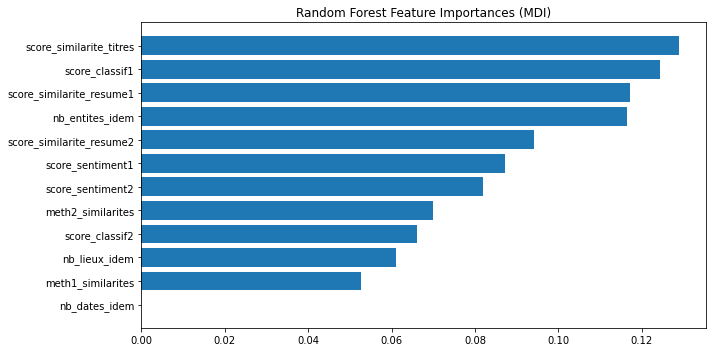

In [125]:
import matplotlib
import matplotlib.pyplot as plt
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:200],ytrain[:200])
res_lda = lda.predict(Xtrain[200:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'],index = range(200,456))],axis=1)
res_final

,Overall,RF,LDA
200,3,2,2
201,2,3,1
202,2,2,1
203,1,2,3
204,3,2,3
...,...,...,...
451,3,3,3
452,1,1,1
453,3,4,4
454,3,3,3


In [127]:
from numpy import around
import numpy
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[200:])*100, decimals=2)
res_lda2

array([[17.07, 49.4 , 22.63, 10.91],
       [63.76, 12.73, 20.21,  3.3 ],
       [56.84,  9.97, 27.34,  5.86],
       ...,
       [ 0.92,  1.2 , 16.84, 81.05],
       [ 7.06,  0.67, 65.93, 26.33],
       [ 7.92,  5.92, 58.32, 27.84]])

**_Remarquer que la classification ne tient pas compte du fait que c'est ordonné en classement 1-2-3-4 : ce qui est TRES important (ex : ligne 55% de 1 - 43% de 4) !! : il faudrait donc faire ressortir un score avec les probas plutot !!!_**

In [128]:
res_rf2 = around(rf.predict_proba(Xtrain[200:])*100, decimals=2)
res_rf2

array([[17., 40., 26., 17.],
       [11., 34., 44., 11.],
       [28., 32., 31.,  9.],
       ...,
       [ 5., 10., 29., 56.],
       [10., 16., 56., 18.],
       [13., 16., 43., 28.]])

In [129]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [130]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob'],index = range(200,456)),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'],index = range(200,456))],axis=1)

In [131]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain[:200],ytrain[:200])
res_knn = knn.predict(Xtrain[200:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[200:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN'],index = range(200,456)),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'],index = range(200,456))],axis=1)

In [132]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xtrain[:200],ytrain[:200])
res_logreg = logreg.predict(Xtrain[200:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[200:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR'],index = range(200,456)),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'],index = range(200,456))],axis=1)

In [133]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(Xtrain[:200],ytrain[:200])
res_ada = ada.predict(Xtrain[200:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[200:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA'],index = range(200,456)),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'],index = range(200,456))],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

In [134]:
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob
200,3,2,2,2,2,2,2,2,3,3,3
201,2,3,1,2,3,2,3,1,2,2,2
202,2,2,1,2,3,2,2,1,3,3,3
203,1,2,3,2,3,2,3,3,3,3,3
204,3,2,3,2,3,2,2,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
451,3,3,3,3,4,3,3,3,3,3,3
452,1,1,1,1,1,1,1,1,1,1,1
453,3,4,4,4,4,4,4,4,4,4,4
454,3,3,3,4,3,4,3,3,4,4,4


Voir ensuite à utiliser les resultats reçus pour obtenir un resultat final : mieux ??

## REGRESSION Sklearn Pycaret

In [135]:
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
turc = pd.read_csv('corpus_tr_notes.csv',index_col=0)
turc = turc[turc.meth1_similarites!='Error']
turc_classif = setup(data = turc[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.2.2
INFO:logs:Initializing setup()
INFO:logs:setup(target=Overall, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transforma

In [136]:
lr = create_model('lr')
rr = create_model('lasso')
etr = create_model('et')
svr = create_model('svm')
adar = create_model('ada')
mlpr = create_model('mlp')

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=7534, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6505,0.8236,0.9075,0.1249,0.2639,0.3173
1,0.6483,0.9693,0.9845,-0.1057,0.3123,0.2981
2,0.6728,0.6817,0.8257,-0.1558,0.2402,0.2177
3,0.6972,0.7512,0.8667,0.1432,0.2722,0.3156
4,0.8179,1.0004,1.0002,-0.1411,0.3002,0.3564
5,0.7697,0.8771,0.9365,0.2649,0.2940,0.4425
6,0.6276,0.5626,0.7501,0.3301,0.2099,0.2709
7,1.0183,1.6198,1.2727,-0.2500,0.3840,0.6339
8,0.8153,1.0602,1.0296,-0.0730,0.3018,0.4095
9,0.6817,0.8041,0.8967,0.1628,0.2623,0.2871


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 1
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lasso, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Lasso Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=7534, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5572,0.4731,0.6878,0.4973,0.2150,0.2865
1,0.6285,0.7178,0.8472,0.1813,0.2407,0.2832
2,0.5550,0.3879,0.6228,0.3424,0.1699,0.2070
3,0.5179,0.3995,0.6321,0.5443,0.1861,0.2162
4,0.6245,0.6640,0.8149,0.2426,0.2331,0.2806
5,0.7551,0.8757,0.9358,0.2661,0.2913,0.4301
6,0.5492,0.4421,0.6649,0.4736,0.1914,0.2438
7,0.8699,1.1001,1.0489,0.1511,0.3299,0.5333
8,0.6045,0.5581,0.7471,0.4351,0.2241,0.2832
9,0.5730,0.4799,0.6927,0.5004,0.2026,0.2521


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 2
INFO:logs:Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7534,
      selection='cyclic', tol=0.0001, warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=et, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Extra Trees Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4933,0.4981,0.7058,0.4707,0.2158,0.2725
1,0.5683,0.6717,0.8195,0.2339,0.2277,0.2650
2,0.5283,0.4136,0.6431,0.2987,0.1750,0.2056
3,0.4362,0.2865,0.5353,0.6732,0.1530,0.1852
4,0.7114,0.8223,0.9068,0.0621,0.2531,0.3174
5,0.6730,0.7269,0.8526,0.3908,0.2697,0.3916
6,0.5561,0.5274,0.7263,0.3720,0.1982,0.2232
7,0.8731,1.1866,1.0893,0.0843,0.3398,0.5467
8,0.6142,0.6093,0.7805,0.3834,0.2283,0.2766
9,0.4765,0.4089,0.6394,0.5743,0.1864,0.2075


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 3
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7534, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=svm, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Imp

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5091,0.4901,0.7001,0.4792,0.2165,0.2776
1,0.5813,0.6791,0.8241,0.2254,0.2287,0.2689
2,0.5163,0.3546,0.5955,0.3988,0.1573,0.1900
3,0.4869,0.4057,0.6369,0.5373,0.1838,0.2084
4,0.6180,0.6781,0.8235,0.2265,0.2308,0.2718
5,0.7076,0.8585,0.9266,0.2805,0.2911,0.4284
6,0.5166,0.4462,0.6680,0.4687,0.1911,0.2337
7,0.8032,1.0651,1.0320,0.1781,0.3291,0.5240
8,0.5721,0.6060,0.7784,0.3867,0.2342,0.2794
9,0.5284,0.4404,0.6636,0.5414,0.1996,0.2292


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 4
INFO:logs:SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=ada, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:AdaBoost Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=7534, shuffle=False), n_jobs=-1
I

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5814,0.5360,0.7321,0.4305,0.2199,0.2893
1,0.5644,0.5300,0.7280,0.3955,0.2092,0.2565
2,0.6029,0.4576,0.6765,0.2242,0.1759,0.2043
3,0.5933,0.4385,0.6622,0.4999,0.1805,0.2283
4,0.7215,0.6629,0.8142,0.2439,0.2244,0.2893
5,0.7769,0.9021,0.9498,0.2439,0.2959,0.4370
6,0.6251,0.5725,0.7566,0.3184,0.2113,0.2560
7,0.8233,0.9524,0.9759,0.2650,0.3091,0.4880
8,0.5778,0.4672,0.6835,0.5271,0.1940,0.2324
9,0.5855,0.4261,0.6528,0.5563,0.1808,0.2251


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 5
INFO:logs:AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=7534)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=mlp, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:MLP Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=7534, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean a

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8781,1.2388,1.1130,-0.3162,0.3215,0.3873
1,0.7102,0.9531,0.9763,-0.0872,0.2510,0.3141
2,0.8360,1.1076,1.0524,-0.8777,0.2721,0.2739
3,0.7172,0.7520,0.8672,0.1422,0.2601,0.2633
4,0.8464,1.0924,1.0452,-0.2460,0.2872,0.3195
5,0.9867,1.7138,1.3091,-0.4364,0.3852,0.5337
6,1.1525,2.6086,1.6151,-2.1060,0.3499,0.4830
7,1.0421,1.5614,1.2496,-0.2049,0.3679,0.5947
8,0.9275,1.2936,1.1374,-0.3093,0.3282,0.3738
9,0.8580,1.3920,1.1798,-0.4494,0.3057,0.3472


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 6
INFO:logs:TunableMLPRegressor(activation='relu', alpha=0.0001, batch_size='auto',
                    beta_1=0.9, beta_2=0.999, early_stopping=False,
                    epsilon=1e-08, hidden_layer_size_0=100,
                    hidden_layer_sizes=[100], learning_rate='constant',
                    learning_rate_init=0.001, max_fun=15000, max_iter=500,
                    momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                    power_t=0.5, random_state=7534, shuffle=True, solver='adam',
                    tol=0.0001, validation_fraction=0.1, verbose=False,
                    warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [137]:
# Linear Regression simple sur scikit learn
essai_classif = turc[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]
lr = LinearRegression()
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [138]:
Xtrain

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,2,0,0,2.95,6.88,-1.66,1.63,10.00,43.13,45.22,26.9,3.9
1,4,0,0,26.43,12.79,0.67,12.70,18.16,48.13,1.49,0.0,0.0
2,3,3,0,6.62,11.28,-5.29,0.20,10.00,46.19,95.14,70.0,102.2
3,15,0,0,54.75,17.53,-1.53,99.34,10.00,22.91,33.76,0.0,0.0
4,0,0,0,-11.10,7.77,24.86,0.03,9.99,32.31,0.06,0.0,111.8
...,...,...,...,...,...,...,...,...,...,...,...,...
451,7,4,0,40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6
452,80,6,0,49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3
453,15,0,0,-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0
454,17,27,0,0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3


In [139]:
lr.fit(Xtrain[:200],ytrain[:200])
res_lr = lr.predict(Xtrain[200:])
res_lr = pd.concat([Xtrain[200:],ytrain[200:],pd.DataFrame(res_lr,columns = ['LR'],index = range(200,456))],axis=1)
res_lr

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,LR
200,21,9,0,11.69,58.43,72.52,99.71,10.02,48.31,99.82,330.5,582.0,3.0,2.288374
201,23,25,0,25.62,52.11,26.18,95.82,10.02,52.72,99.04,450.1,815.6,2.0,2.028869
202,15,21,0,45.16,81.92,2.24,91.52,10.01,37.29,99.37,472.9,540.9,2.0,2.164164
203,5,9,0,52.91,32.09,-2.35,99.73,10.00,79.54,68.44,19.5,279.0,1.0,2.749458
204,17,10,0,38.69,59.87,39.41,98.53,10.00,55.57,99.04,221.7,237.6,3.0,2.437389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,7,4,0,40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6,3.0,3.156753
452,80,6,0,49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3,1.0,-0.709194
453,15,0,0,-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0,3.0,3.542409
454,17,27,0,0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3,3.0,3.106387


In [140]:
res_final = pd.concat([res_final,res_lr['LR']],axis=1)

remarque : les résultats sont assez différents : voir à utiliser différents algos ? <br/>
En classification : Logistic Regression - XG Boost ?? - Linear Discriminant Analysis qui était OK en essai - Bayésien ? ADA Boost ? SVM ? : 1 score de classif en utilisant proba <br/>
puis un score de régression : la Régression PLS peut être intéressante car les notes doivent très corrélées entre elles - Lasso ou ridge ne servent à rien a priori - SVR - RDN ?

In [141]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(Xtrain[:200],ytrain[:200])
res_pls = list(pls.predict(Xtrain[200:]).flatten())
res_pls = pd.concat([res_lr,pd.DataFrame(res_pls,columns = ['PLS'],index = range(200,456))],axis=1)
res_pls

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,LR,PLS
200,21,9,0,11.69,58.43,72.52,99.71,10.02,48.31,99.82,330.5,582.0,3.0,2.288374,2.313205
201,23,25,0,25.62,52.11,26.18,95.82,10.02,52.72,99.04,450.1,815.6,2.0,2.028869,2.072613
202,15,21,0,45.16,81.92,2.24,91.52,10.01,37.29,99.37,472.9,540.9,2.0,2.164164,2.168679
203,5,9,0,52.91,32.09,-2.35,99.73,10.00,79.54,68.44,19.5,279.0,1.0,2.749458,2.777121
204,17,10,0,38.69,59.87,39.41,98.53,10.00,55.57,99.04,221.7,237.6,3.0,2.437389,2.443833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,7,4,0,40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6,3.0,3.156753,3.194224
452,80,6,0,49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3,1.0,-0.709194,-0.465628
453,15,0,0,-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0,3.0,3.542409,3.621809
454,17,27,0,0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3,3.0,3.106387,3.077269


les scores de la regression PLS sont assez proches de la régression linéaire !

In [142]:
res_final = pd.concat([res_final,res_pls['PLS']],axis=1)
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob,LR,PLS
200,3,2,2,2,2,2,2,2,3,3,3,2.288374,2.313205
201,2,3,1,2,3,2,3,1,2,2,2,2.028869,2.072613
202,2,2,1,2,3,2,2,1,3,3,3,2.164164,2.168679
203,1,2,3,2,3,2,3,3,3,3,3,2.749458,2.777121
204,3,2,3,2,3,2,2,3,2,2,2,2.437389,2.443833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,3,3,3,3,4,3,3,3,3,3,3,3.156753,3.194224
452,1,1,1,1,1,1,1,1,1,1,1,-0.709194,-0.465628
453,3,4,4,4,4,4,4,4,4,4,4,3.542409,3.621809
454,3,3,3,4,3,4,3,3,4,4,4,3.106387,3.077269


**Compléments d'information**

In [143]:
visuel = turc[['title_1', 'title_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2',
    'nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
    'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
    'score_sentiment2', 'meth1_similarites', 'meth2_similarites','Overall']]
visuel

,title_1,title_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,nb_entites_idem,nb_lieux_idem,nb_dates_idem,entites_idem,...,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall
0,Tekirdağ balıkçı barınağında koronavirüs tedbi...,İzmir'de toplu ulaşım kullanımı yüzde 79 azaldı,Tekirdağ'da balıkçı barınağında koronavirüs te...,Tekirdağ balıkçı barınağında коронаvirüs tedbi...,"İzmir'de, yeni tip koronavirüs ( Kovid - 19 ) ...",İzmir'de toplu ulaşım kullanımı yüzde 79 azald...,2,0,0,"['Belediyesi', 'Büyükşehir']",...,2.95,6.88,-1.66,1.63,10.00,43.13,45.22,26.9,3.9,3.0
1,ATV Esra Erol canlıda Baha Akkoç ifşası! Silah...,Esra Erol son bölümde şok fuhuş iddiası! 3 yaş...,"Star Gazetesi yazarı Baha Baha Baha, Ağrı'da k...",Cumhurbaşkanı Recep Tayyip Erdoğan'ın oğlu Ley...,"2015 yılında Manisa'da evlenen Ali Akkoç, iş a...","Adana'da bir mektup bırakan Ali Akkoç , Adana'",4,0,0,"['Erol', 'Esra']",...,26.43,12.79,0.67,12.70,18.16,48.13,1.49,0.0,0.0,1.0
2,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,ABD'de dayanıklı mal siparişleri şubatta arttı,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,CANLI Koronavirüs haritası – 26 Mart Perşembe ...,"ABD'de dayanıklı mal siparişleri, şubatta aylı...","ABD'de dayanıklı mal siparişleri, şubatta aylı...",3,3,0,['Bakanlığı'],...,6.62,11.28,-5.29,0.20,10.00,46.19,95.14,70.0,102.2,4.0
3,Ekonomik Örgütler: Sosyal Sigortalar’a kayıtlı...,KKTC'de yüksek memur maaşlarında kesintiye gid...,"Türkiye İş - İş, Sosyal Güvenlik Kurumu ’ ndan...","Ekonomik Örgütler , Sosyal Sigortalar’a kayıtl...",Kuzey Kıbrıs Türk Cumhuriyeti ( KKTC ) Başbaka...,Kuzey Kıbrıs Türk Cumhuriyeti ( KKTC ) Başbaka...,15,0,0,"['KKTC', 'Türk', 'Kıbrıs']",...,54.75,17.53,-1.53,99.34,10.00,22.91,33.76,0.0,0.0,3.5
4,Roger Federer'den büyük bağış!,"YouTube, varsayılan video kalitesini düşürdü","İsviçreli tenisçi Federer, ülkesinde Corona vi...","Spor Arena Dış Haber , İsviçreli tenisçi Roger...","YouTube, dünya genelindeki varsayılan video ka...",Avrupa Birliği'nin internet kullanımı çağrısın...,0,0,0,[],...,-11.10,7.77,24.86,0.03,9.99,32.31,0.06,0.0,111.8,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...",BM'den Yemen'de kadınların doğumda ölüm riski ...,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden zarar","Birleşmiş Milletler ( BM ), Yemen'de kadınları...",BM'den Yemen'de kadınların doğumda ölüm riski ...,7,4,0,"['Milletler', 'Birleşmiş', 'BM']",...,40.74,42.28,32.80,26.99,10.01,95.11,99.79,34.2,9.6,3.0
461,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Fabio Capello: Koronavirüs sonrası La Liga'da ...,Yeni tip koronavirüs ( Kovid - 19 ) salgınının...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs salgınının ekonomideki et...,Yeni tip koronavirüs ( Kovid-19) salgınının ek...,80,6,0,"['Barcelona', 'Sağlık', '##lo', '1', '##io', '...",...,49.68,91.60,8.60,75.16,10.02,34.09,45.62,1654.8,1718.3,1.0
462,Saray da çare olmadı: 'Borca boğulan dev kulüp...,TFF’den jet yanıt! ''Bizi hedef gösteriyorlar'',"Beşiktaş Başkanı Ahmet Nur Çebi, kulübün tüm g...","Trabzonspor Başkanı Ahmet Nur Çebi , 'Elektrik...","Bank Asya 1. Ligi takımlarından Beşiktaş, Beşi...","TFF , Beşiktaş'ın faiz üzerinden 'Kulüplerin T...",15,0,0,"['Ahmet', 'Nur', '##ebi', 'Ç', 'Türkiye', 'Fut...",...,-4.95,12.07,47.18,1.26,10.01,69.74,99.52,0,0,3.0
463,Ergene Belediyesi yol çalışmalarına aksatmadan...,Ergene'de Ahimehmet ve Yeşiltepe mahallelerind...,Ergene Belediyesi yol çalışmalarına aksatmadan...,Ergene Belediyesi yol çalışmalarına aksatmadan...,Covid - 19 salgınından vatandaşların korunması...,Ergene'de Ahimehmet ve Yeşiltepe mahallelerind...,17,27,0,"['Büyükşehir', 'Ras', '##vi', 'Yüksel', '-', '...",...,0.19,32.09,-2.92,22.00,10.58,66.80,29.40,0,19.3,3

In [144]:
data.columns

Index(['pair_id', 'pair_lang', 'source_url_1', 'publish_date_1',
       'source_url_2', 'publish_date_2', 'title_1', 'text_1',
       'meta_description_1', 'meta_keywords_1', 'title_2', 'text_2',
       'meta_description_2', 'meta_keywords_2', 'Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone', 'ligne'],
      dtype='object')

In [145]:
comp_turc = data.loc[data.pair_lang == 'tr_tr',['source_url_1', 'publish_date_1','source_url_2', 'publish_date_2', 
       'meta_description_1', 'meta_keywords_1', 'meta_description_2', 'meta_keywords_2','Overall']].reset_index(drop=True)

In [146]:
comp_turc

,source_url_1,publish_date_1,source_url_2,publish_date_2,meta_description_1,meta_keywords_1,meta_description_2,meta_keywords_2,Overall
0,https://www.haberler.com,,https://www.haberler.com,,Tekirdağ balıkçı barınağında koronavirüs tedbi...,"['Süleymanpaşa', 'Tekirdağ', 'Güncel']","İzmir'de, yeni tip koronavirüs (Kovid-19) tedb...","['İzmir', 'Güncel']",3.0
1,https://www.internethaber.com,,https://www.takvim.com.tr,,ATV'de canlı yayınlanan Esra Erol'da programın...,"['esra erol', 'atv']",,[''],1.0
2,https://www.takvim.com.tr,,https://www.sondakika.com,Wed Mar 25 15:58:12 2020,,[''],"ABD’de dayanıklı mal siparişleri, şubatta aylı...",[''],4.0
3,https://www.kibrisgazetesi.com,,http://www.haberler.com,,,[''],"Başbakan Ersin Tatar, üç aylık bir süre için t...","['Ersin Tatar', 'Kıbrıs', 'Tatar', 'Dünya']",3.5
4,https://www.haberler.com,Wed Mar 25 16:20:00 2020,https://www.sozcu.com.tr,,Spor Arena Dış Haber İsviçreli tenisçi Roger F...,"['Roger Federer', 'Sosyal Medya', 'İsviçre', '...","YouTube, varsayılan video kalitesini düşürdü Y...","['YouTube', '', 'varsayılan', 'video', 'kalite...",4.0
...,...,...,...,...,...,...,...,...,...
460,http://www.haberler.com,,https://www.haberler.com,,"Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",3.0
461,https://www.haberler.com,,https://www.aksam.com.tr,,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0
462,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca"", '...","Federasyon, Başkan Çebi’nin yaptığı açıklamala...",[''],3.0
463,https://www.haberler.com,,https://www.haberler.com,,"Tekirdağ'ın Ergene Belediyesi, Covid-19 salgın...","['Rasim Yüksel', 'Koronavirüs', 'Tekirdağ', 'E...",Covid-19 salgınından vatandaşların korunması i...,"['Koronavirüs', 'Yeşiltepe', 'Yaşam', 'Haber']",3.0
